In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields)
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])

In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS())

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric())

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [15]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [16]:
#Getting the Orbits of Subhalos
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [17]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [18]:
len(rot_orbits)

1072

In [19]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


In [20]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [39]:
top_bound = mwsts['Gaia-1-I21'].length + 5*u.deg
low_bound = mwsts['Gaia-1-I21'].length - 5*u.deg

for st in mwsts:
    if (mwsts[st].length >= low_bound) & (mwsts[st].length <= top_bound):
        print(st, mwsts[st].length)

20.0-1-M18 36d37m11.1231s
Acheron-G09 36d31m55.5299s
Gaia-1-I21 34d34m12.906s
Parallel-W18 37d39m56.4195s
Slidr-I21 33d36m50.9947s
Svol-I21 34d39m25.9664s


In [22]:
mwsts['Gaia-1-I21'].length

<Angle 34.57025167 deg>

In [42]:
LMC=trot[np.argmax(trot['mvir'])]
LMC_dist=np.sqrt(LMC['x']**2+LMC['y']**2+LMC['z']**2)

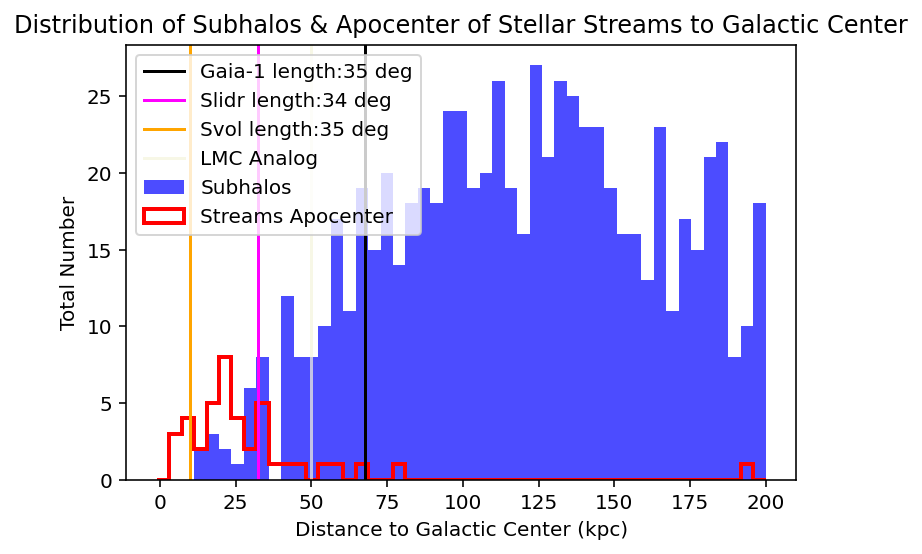

In [44]:
plt.figure()
plt.hist(subhalo_dist, bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
plt.hist(r_apo.values(),bins=np.linspace(-1,200,50), color='red', histtype='step', linewidth=2, label='Streams Apocenter')
plt.axvline(r_apo['Gaia_1'], color='black', label = "Gaia-1 length:{:.0f} deg".format(mwsts['Gaia-1-I21'].length.deg))
plt.axvline(r_apo['Slidr'],color='magenta', label = "Slidr length:{:.0f} deg".format(mwsts['Slidr-I21'].length.deg))
plt.axvline(r_apo['Svol'],color='orange', label = "Svol length:{:.0f} deg".format(mwsts['Svol-I21'].length.deg))
plt.axvline(50, color='beige', alpha=0.7, label='LMC Analog')
plt.title('Distribution of Subhalos & Apocenter of Stellar Streams to Galactic Center') 
plt.xlabel('Distance to Galactic Center (kpc)')
plt.ylabel('Total Number')
plt.legend(loc='best')

In [24]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

#Information for Slidr
c = coord.SkyCoord(ra=160.05*u.deg, dec=10.22*u.deg, distance=2.99*u.kpc, pm_ra_cosdec=-24.6*u.mas/u.yr,
                  pm_dec=-6.65*u.mas/u.yr, radial_velocity=-87.98*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

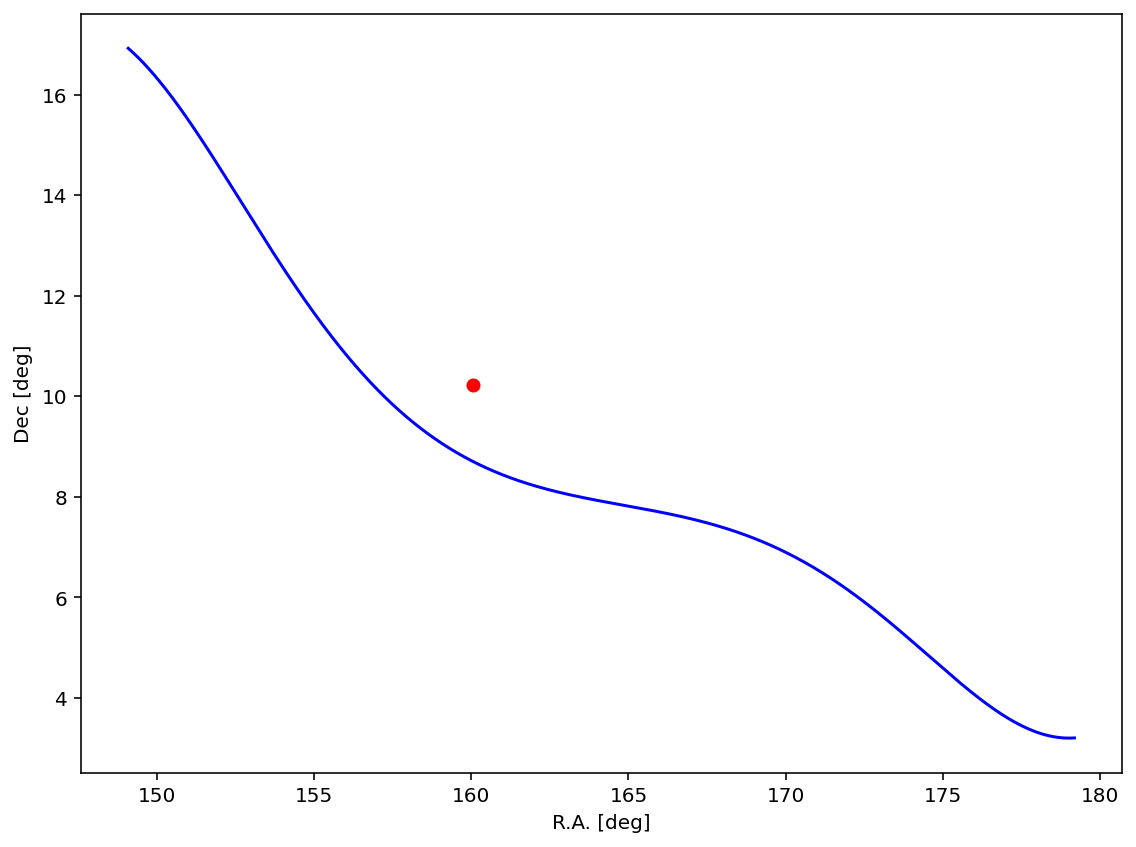

In [25]:
name='Slidr-I21'
plt.figure(figsize=(8,6))
plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
#plt.gca().set_aspect('equal')
plt.tight_layout()

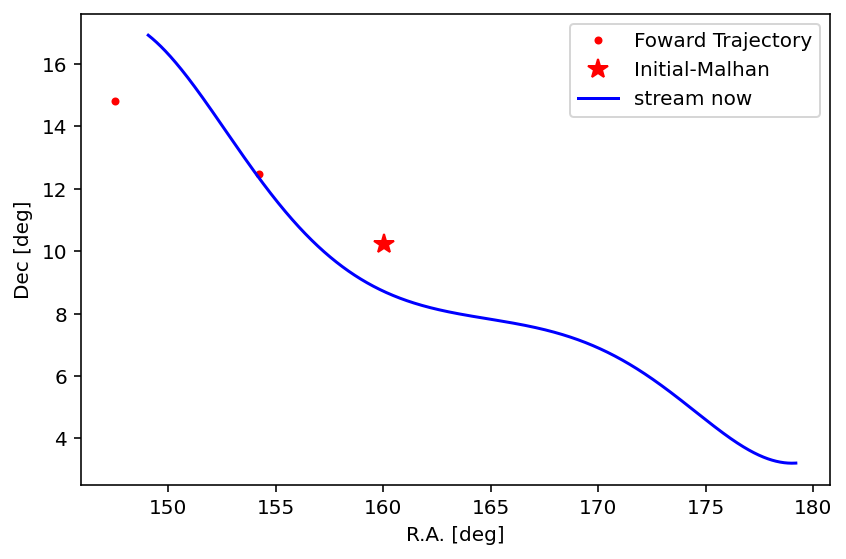

In [26]:
dt = 1*u.Myr
Nstep_foward = 2
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='Foward Trajectory')
plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='Initial-Malhan', ms=10)
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

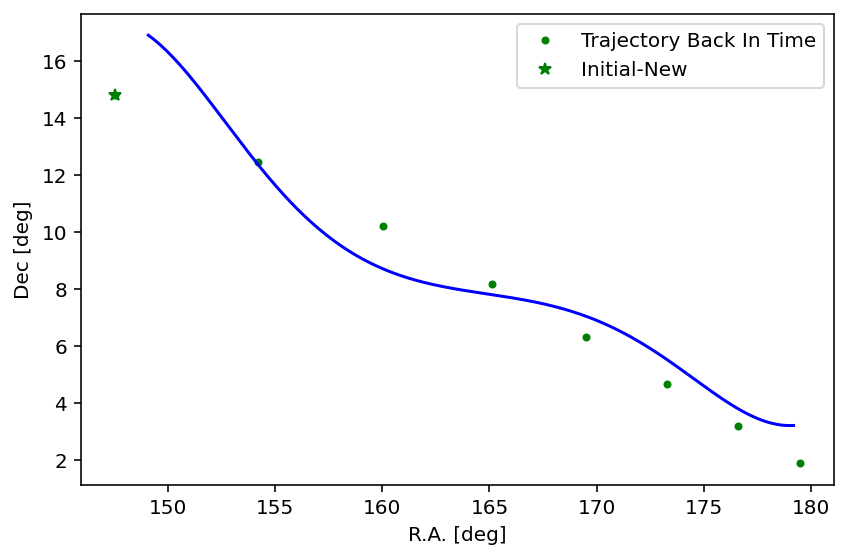

In [27]:
w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = 7
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

plt.plot(orbit_sky.ra.wrap_at(180*u.deg), orbit_sky.dec, '.g', label='Trajectory Back In Time')
plt.plot(orbit_sky.ra.wrap_at(180*u.deg)[0], orbit_sky.dec[0], '*g', label='Initial-New')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

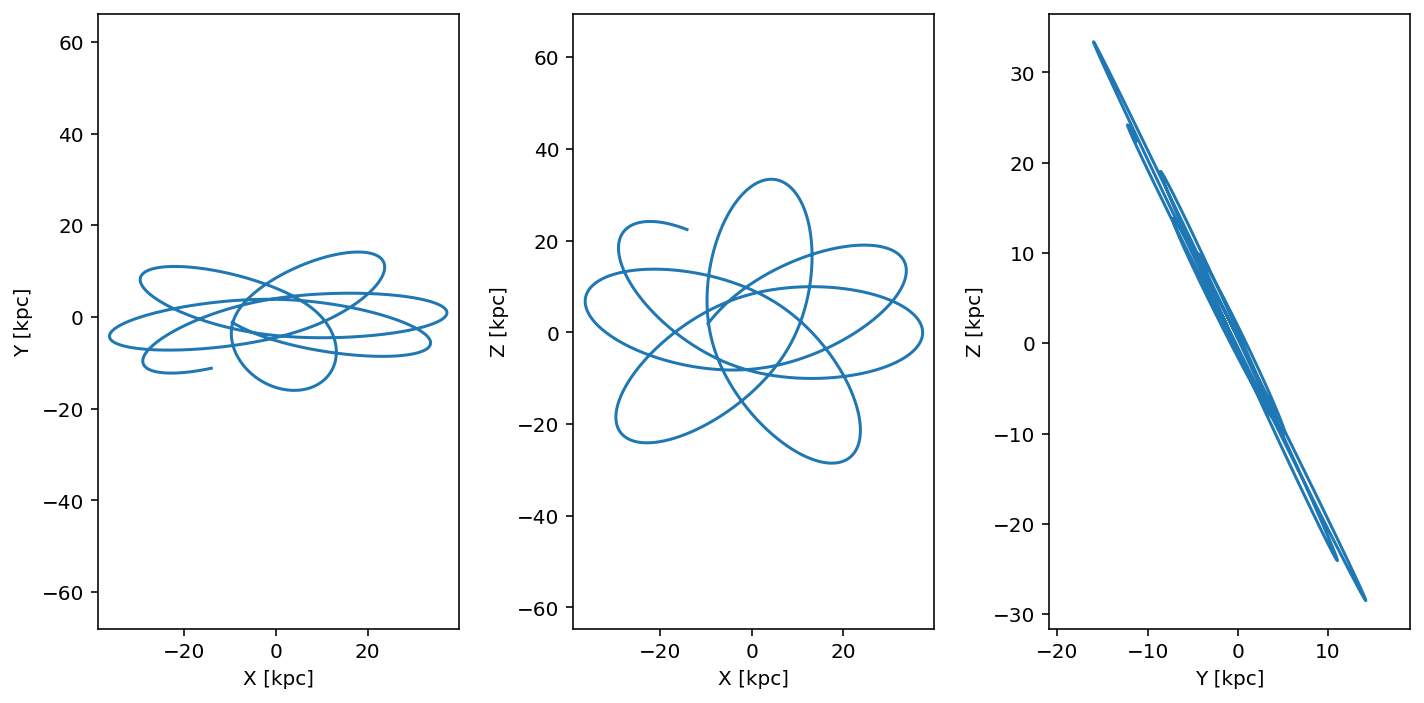

In [28]:
#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

fig, ax = plt.subplots(1,3,figsize=(10,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

plt.tight_layout()

In [29]:
# Compared to Slidr peri-8.7 apo-(32.3)
orbit_long.pericenter(), orbit_long.apocenter()

(<Quantity 8.86649403 kpc>, <Quantity 37.31356674 kpc>)

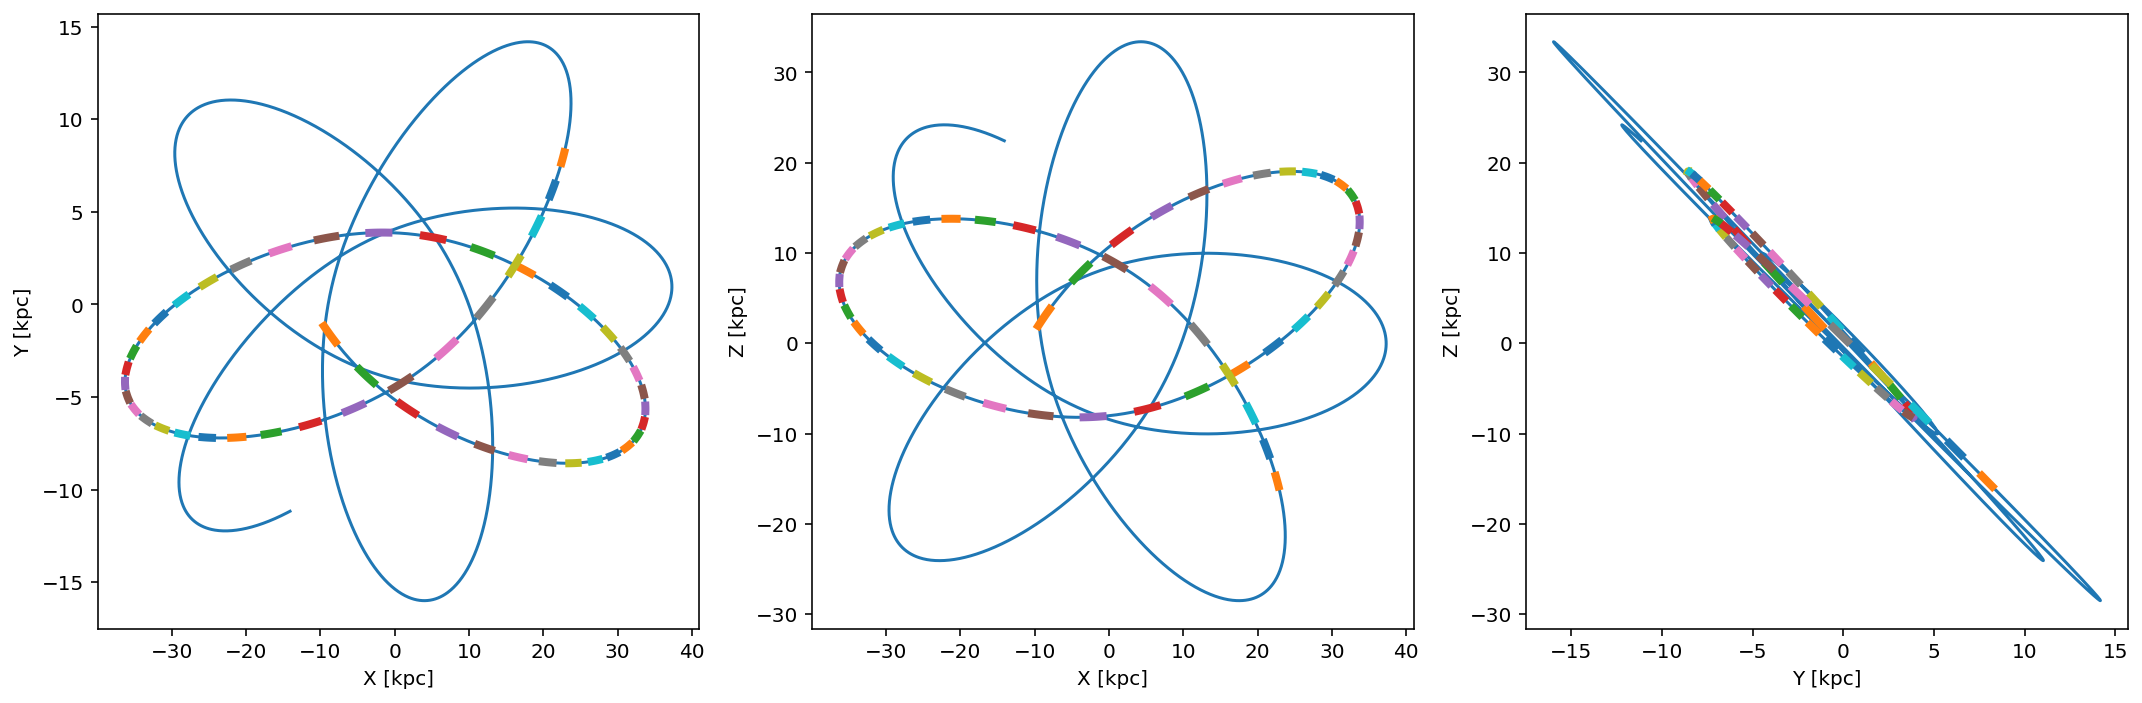

In [30]:
#Trajectory of the Stream in the Past

Nstep = 8 

fig, ax = plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,51)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    plt.sca(ax[0])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep], '-', lw=4)
    
    plt.sca(ax[1])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=4)
    
    plt.sca(ax[2])
    plt.plot(orbit_long.pos.y[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=4)

plt.tight_layout()

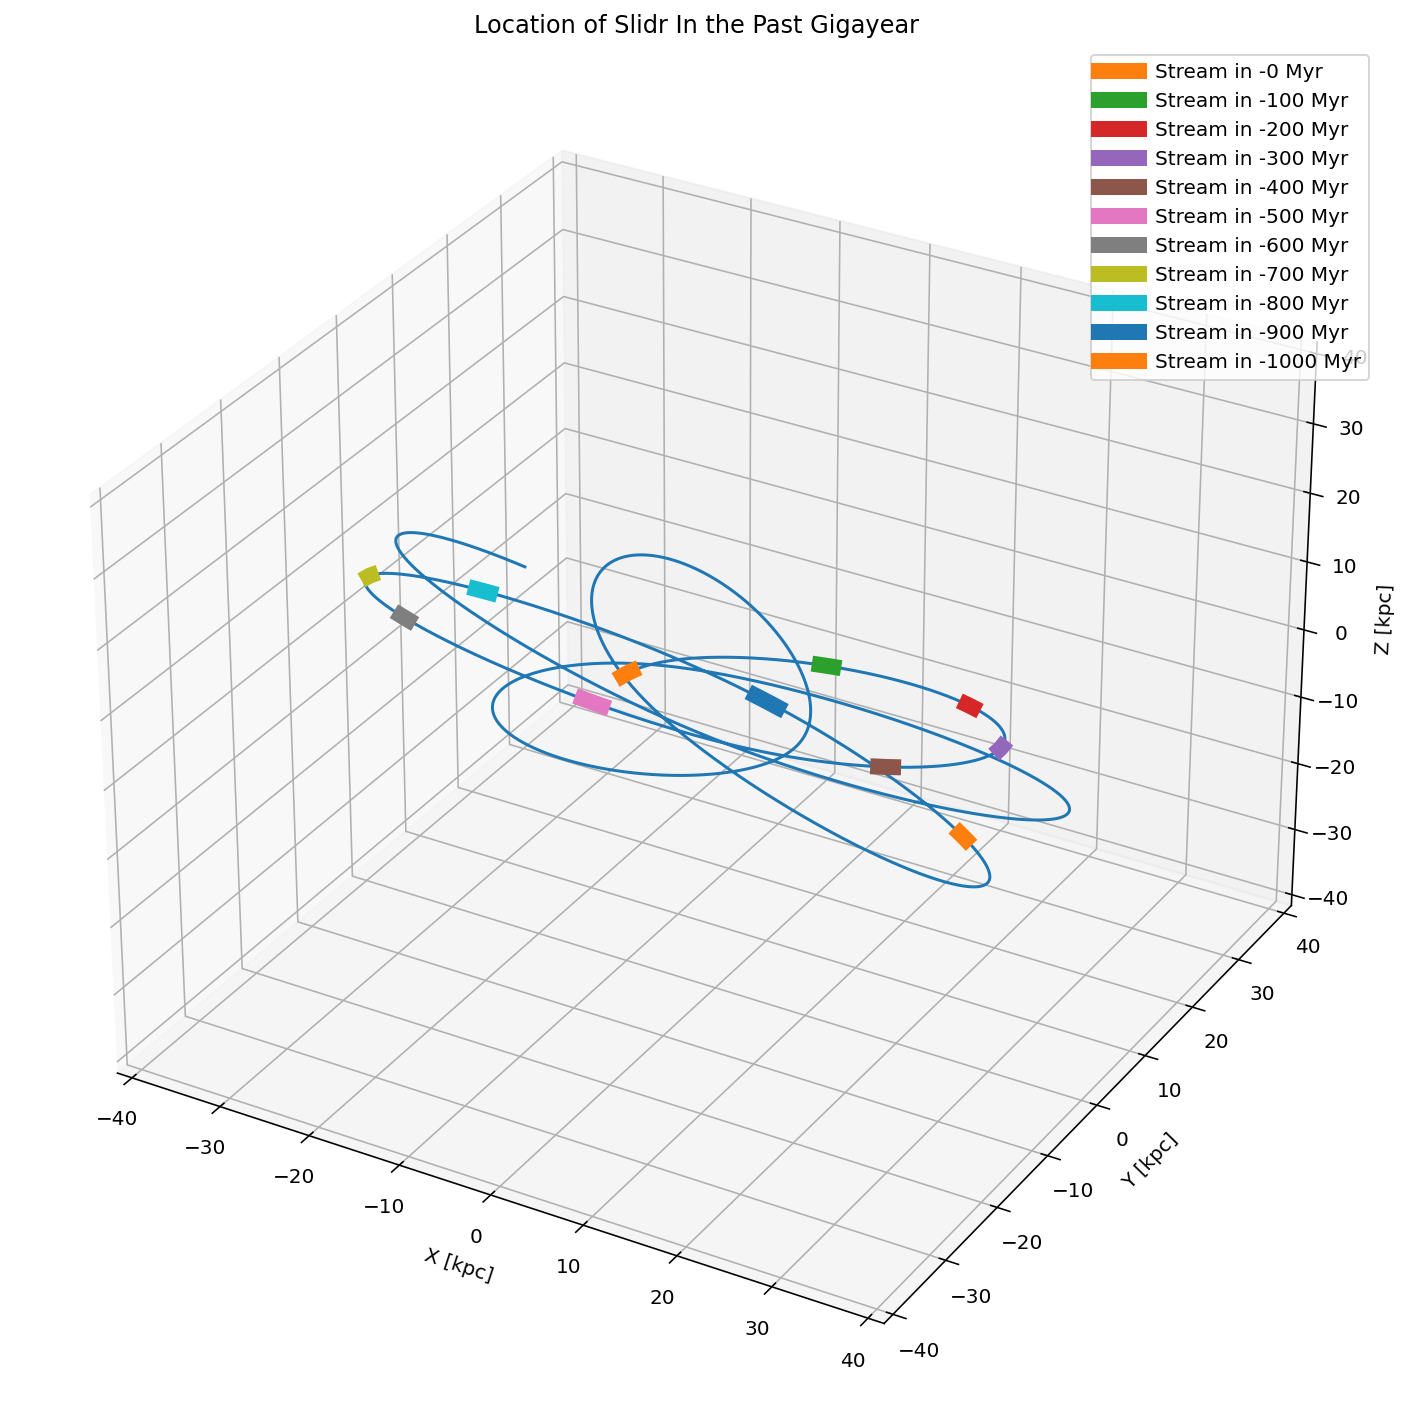

In [31]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', lw=8,
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Slidr In the Past Gigayear')
plt.tight_layout()

In [32]:
Nstep=8
times = np.linspace(0,1000,21)*u.Myr
#times_new = times[1:]
dt = 1*u.Myr

data_all_Slidr = pd.DataFrame()
for st_time in times:
    t = int((st_time/dt).decompose())
    print(st_time)
    data_new = {'Slidr':[st_time]}
    data_temp = pd.DataFrame(data=data_new)
    for subh in range(len(trot['x'])): #subh stands for individual subhalo
        dist_x = orbit_long.pos.x[t:t+Nstep] - rot_orbits[subh,t,0]*u.kpc
        dist_y = orbit_long.pos.y[t:t+Nstep] - rot_orbits[subh,t,1]*u.kpc
        dist_z = orbit_long.pos.z[t:t+Nstep] - rot_orbits[subh,t,2]*u.kpc
        tot_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
        min_dist = np.amin(tot_dist)
        data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [min_dist.value]
    data_all_Slidr = data_all_Slidr.append(data_temp, ignore_index=True)

0.0 Myr
50.0 Myr
100.0 Myr
150.0 Myr
200.0 Myr
250.0 Myr
300.0 Myr
350.0 Myr
400.0 Myr
450.0 Myr
500.0 Myr
550.0 Myr
600.0 Myr
650.0 Myr
700.0 Myr
750.0 Myr
800.0 Myr
850.0 Myr
900.0 Myr
950.0 Myr
1000.0 Myr


In [33]:
data_all_Slidr.to_csv('20220811_Complete_Data_Subhalo_to_Slidr_Distance_Over_Time.csv',index=False)


In [34]:
data_all_temp = data_all_Slidr.iloc[: , 1:]
data_all_temp;

In [35]:
data_all_temp.min(axis=1)

0      3.567807
1     13.260463
2      9.334893
3      8.659968
4     12.779870
5      5.595639
6      6.621598
7      4.369649
8      8.759707
9      4.404535
10     9.539952
11     3.927733
12    12.495170
13    16.941763
14    10.300588
15    13.203949
16     8.148425
17    11.792554
18     8.351665
19     8.896142
20    10.083565
dtype: float64

In [36]:
data_all_temp.idxmin(axis=1)

0      Subhalo_976 (kpc)
1       Subhalo_73 (kpc)
2     Subhalo_1026 (kpc)
3       Subhalo_51 (kpc)
4      Subhalo_873 (kpc)
5      Subhalo_491 (kpc)
6      Subhalo_491 (kpc)
7      Subhalo_117 (kpc)
8      Subhalo_756 (kpc)
9       Subhalo_73 (kpc)
10     Subhalo_688 (kpc)
11     Subhalo_688 (kpc)
12     Subhalo_533 (kpc)
13     Subhalo_449 (kpc)
14     Subhalo_116 (kpc)
15     Subhalo_951 (kpc)
16     Subhalo_170 (kpc)
17      Subhalo_73 (kpc)
18     Subhalo_966 (kpc)
19      Subhalo_17 (kpc)
20     Subhalo_537 (kpc)
dtype: object

(-40.0, 40.0)

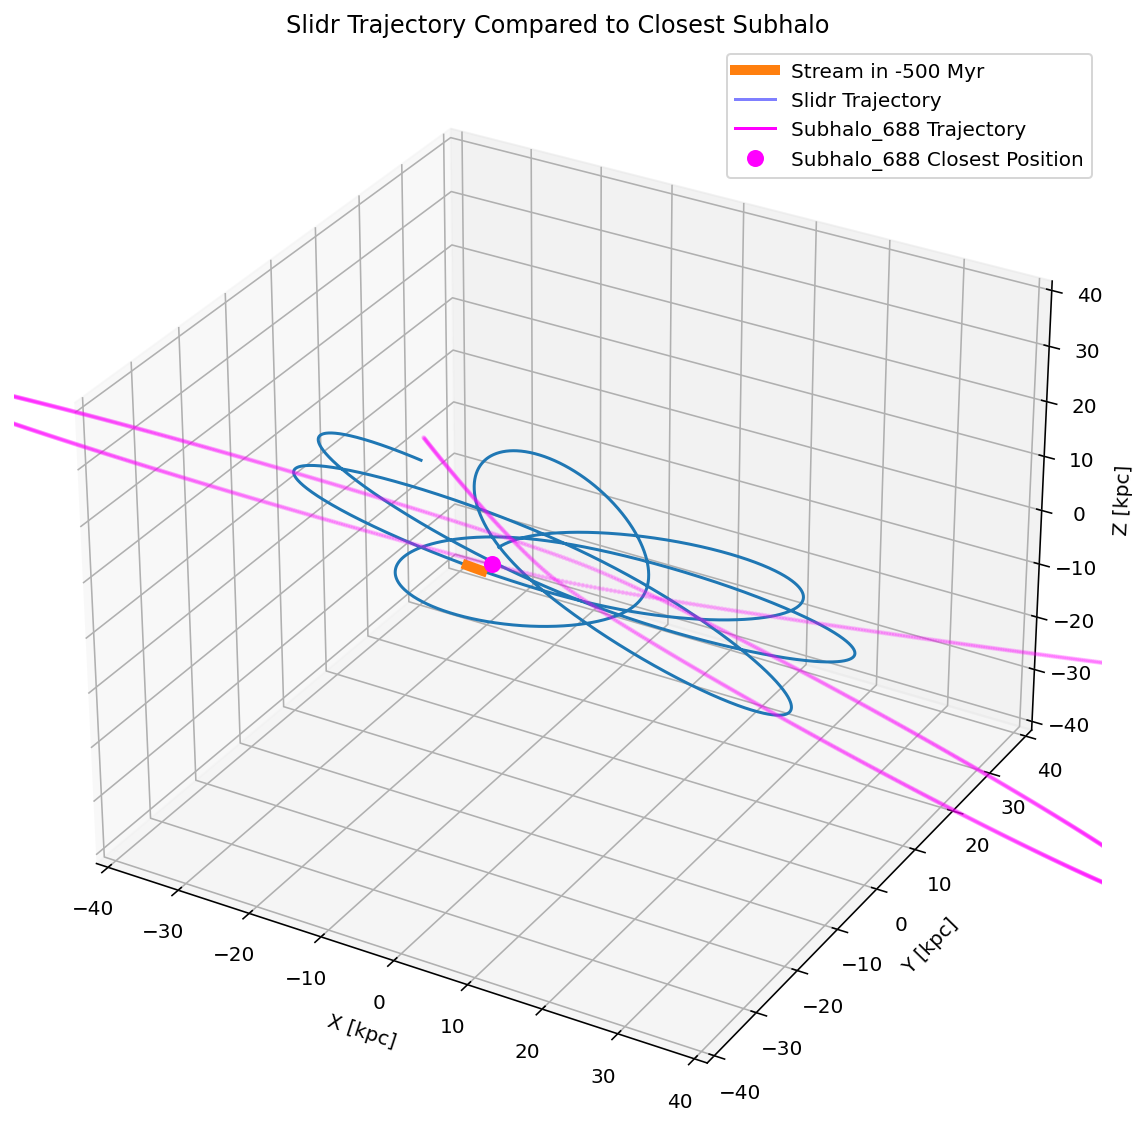

In [37]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

# orbital segments of past positions of the stream
# times = np.linspace(0,1000,21)*u.Myr
# for tm in times:
tm = 500*u.Myr
t = int((tm/dt).decompose())
ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
        orbit_long.pos.z[t:t+Nstep], '-', lw=5,
        label='Stream in {:g}'.format(-tm))
    
ax.scatter(rot_orbits[688,:,0], rot_orbits[688,:,1], rot_orbits[688,:,2], color='magenta', 
           s=2, alpha=0.2)
plt.plot(1000,1000,1000, '-',color='blue',alpha=0.5, label='Slidr Trajectory',
        ms=20)
plt.plot(1000,1000,1000, '-', color='magenta', ms=30, label='Subhalo_688 Trajectory')
plt.plot(rot_orbits[688,500,0], rot_orbits[688,500,1], rot_orbits[688,500,2], '.', color='magenta',
        ms=15, label='Subhalo_688 Closest Position')

plt.legend(loc='best')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best')
plt.title('Slidr Trajectory Compared to Closest Subhalo')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)

In [13]:
Nstep=8
times = np.linspace(0,1000,21)*u.Myr
#times_new = times[1:]
dt = 1*u.Myr

data_singular_Slidr = pd.DataFrame()
for st_time in times:
    t = int((st_time/dt).decompose())
    print(st_time)
    data_new = {'Slidr_to_688':[st_time]}
    data_temp = pd.DataFrame(data=data_new)
    #for subh in range(len(trot['x'])): #subh stands for individual subhalo
    dist_x = orbit_long.pos.x[t:t] - rot_orbits[688,t,0]*u.kpc
    dist_y = orbit_long.pos.y[t:t] - rot_orbits[688,t,1]*u.kpc
    dist_z = orbit_long.pos.z[t:t] - rot_orbits[688,t,2]*u.kpc
    tot_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
    #min_dist = np.amin(tot_dist)
    data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [tot_dist.value]
data_singular_Slidr = data_singular_Slidr.append(data_temp, ignore_index=True)

0.0 Myr


NameError: name 'orbit_long' is not defined

In [ ]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

#Information for Slidr
c = coord.SkyCoord(ra=351.95*u.deg, dec=-51.74*u.deg, distance=11.39*u.kpc, pm_ra_cosdec=7.23*u.mas/u.yr,
                  pm_dec=-4.37*u.mas/u.yr, radial_velocity=-1.29*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

In [ ]:
name='Jhelum-b-B19'
plt.figure(figsize=(8,6))
plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
#plt.gca().set_aspect('equal')
plt.tight_layout()

In [ ]:
dt = 1*u.Myr
Nstep_foward = 6
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='Foward Trajectory')
plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='Initial-Malhan', ms=10)
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

In [ ]:
w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = 22
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

plt.plot(orbit_sky.ra.wrap_at(180*u.deg), orbit_sky.dec, '.g', label='Trajectory Back In Time')
plt.plot(orbit_sky.ra.wrap_at(180*u.deg)[0], orbit_sky.dec[0], '*g', label='Initial-New')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

In [ ]:
#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

fig, ax = plt.subplots(1,3,figsize=(10,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

plt.tight_layout()

In [ ]:
# Compared to Jhelum peri-8.7 apo-(24.5)
orbit_long.pericenter(), orbit_long.apocenter()

In [ ]:
#Trajectory of the Stream in the Past

Nstep = 22 

fig, ax = plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,51)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    plt.sca(ax[0])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep], '-', lw=4)
    
    plt.sca(ax[1])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=4)
    
    plt.sca(ax[2])
    plt.plot(orbit_long.pos.y[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=4)

plt.tight_layout()

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', lw=8,
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Jhelum In the Past Gigayear')
plt.tight_layout()

In [ ]:
Nstep=22
times = np.linspace(0,1000,21)*u.Myr
#times_new = times[1:]
dt = 1*u.Myr

data_all_Jhelum = pd.DataFrame()
for st_time in times:
    t = int((st_time/dt).decompose())
    print(st_time)
    data_new = {'Jhelum':[st_time]}
    data_temp = pd.DataFrame(data=data_new)
    for subh in range(len(trot['x'])): #subh stands for individual subhalo
        dist_x = orbit_long.pos.x[t:t+Nstep] - rot_orbits[subh,t,0]*u.kpc
        dist_y = orbit_long.pos.y[t:t+Nstep] - rot_orbits[subh,t,1]*u.kpc
        dist_z = orbit_long.pos.z[t:t+Nstep] - rot_orbits[subh,t,2]*u.kpc
        tot_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
        min_dist = np.amin(tot_dist)
        data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [min_dist.value]
    data_all_Jhelum = data_all_Jhelum.append(data_temp, ignore_index=True)

In [ ]:
data_all_Jhelum.to_csv('20220811_Complete_Data_Subhalo_to_Jhelum_Distance_Over_Time.csv',index=False)


In [ ]:
data_all_temp = data_all_Jhelum.iloc[: , 1:]
data_all_temp;

In [ ]:
data_all_temp.min(axis=1)

In [ ]:
data_all_temp.idxmin(axis=1)

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
#times = np.linspace(0,1000,1)*u.Myr
#for tm in times:
#    t = int((tm/dt).decompose())
#    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
#             orbit_long.pos.z[t:t+Nstep], '-', lw=5,
#             label='Stream in {:g}'.format(-tm))
    
ax.scatter(rot_orbits[588,:,0], rot_orbits[588,:,1], rot_orbits[588,:,2], color='magenta', 
           s=2, alpha=0.2)
plt.plot(1000,1000,1000, '-',color='blue',alpha=0.5, label='Jhelum Trajectory',
        ms=20)
plt.plot(1000,1000,1000, '-', color='magenta', ms=30, label='Subhalo_878 Trajectory')
plt.plot(rot_orbits[588,10,0], rot_orbits[588,10,1], rot_orbits[588,10,2], '.', color='magenta',
        ms=15, label='Subhalo_588 Closest Position')

plt.legend(loc='best')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best')
plt.title('Jhelum Trajectory Compared to Closest Subhalo')
ax.set_xlim(-150,150)
ax.set_ylim(-150,40)
ax.set_zlim(-150,40)